# Required libraries

In [ ]:
requirements = ROOT_PATH + "/requirements.txt"
%pip install -r {requirements}

In [ ]:
import cv2
import os
import time
import numpy as np
import h5py
import os, random
import matplotlib.pylab as plt
import keras.utils.vis_utils as vutil
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose, ZeroPadding2D, Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, Add
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Lambda, add, LSTM, GRU, TimeDistributed, concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import conv_utils
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.optimizers import SGD, Adam, AdamW, RMSprop
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys
from PIL import Image
%matplotlib inline

# Additional function to show image and starts parameters

In [114]:
def show(image, cmap='gray', ax=None):
    if ax is None:
        plt.figure()
    
    plt.imshow(image[:,:,::-1].astype('uint8'), cmap=cmap)

In [115]:
FRAME_H, FRAME_W = 112, 112
TIMESTEPS = 16

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Code up the generators frames from video

A short snippet to create training set and validation set from the given video data.

In [10]:
#Creating image with labels from video on own computer (ANACONDA)

label_inp = open("./data/train.txt").readlines()

video_reader = cv2.VideoCapture("./data/train.mp4")
train_image = './data/images/'
train_label = open('./data/labels.txt', 'w')

counter = 0

while(True):
    ret, frame = video_reader.read()

    if ret == True:
        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame)
        train_label.write(label_inp[counter])
        counter += 1
    else:
        break

video_reader.release()
train_label.close()


' Creating image with labels from video on own computer (ANACONDA)\nlabel_inp = open("./data/train.txt").readlines()\n\nvideo_reader = cv2.VideoCapture("./data/train.mp4")\ntrain_image = \'./data/images/\'\ntrain_label = open(\'./data/labels.txt\', \'w\')\n\ncounter = 0\n\nwhile(True):\n    ret, frame = video_reader.read()\n\n    if ret == True:\n        cv2.imwrite(train_image + str(counter).zfill(6) + \'.png\', frame)\n        train_label.write(label_inp[counter])\n        counter += 1\n    else:\n        break\n\nvideo_reader.release()\ntrain_label.close()\n'

# Data augmenation

These are a set of functions to add disturtances to the images used during the training process.

In [118]:
sometime = lambda aug: iaa.Sometimes(0.3, aug) #randomly apply some of the augmentations with a prob of 0.3
sequence = iaa.Sequential([ #sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            #sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            #sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.0, 0.1), size_percent=(0.01, 0.02), per_channel=0.2)),
                            #sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def normalize(image):
    return image - [104.00699, 116.66877, 122.67892] #image - [mean pixel values]

def augment(image, flip, bright_factor):
    # random disturbances borrowed from IAA
    image = sequence.augment_image(image)
    
    # random brightness change
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    # random flip (vertical axis)
    if flip:
        image = cv2.flip(image, 1)
                
    return image

# Batch Generator 

This is the class to generate batches for both training and validation.

In [119]:
class BatchGenerator:
    def __init__(self, indices, batch_size, timesteps=1, shuffle=True, jitter = True, norm=True, overlap=False):
        #self.file_path  = file_path
        self.batch_size = batch_size
        self.timesteps  = timesteps
        
        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.images = sorted(os.listdir('images/'))
        self.labels = open('labels.txt').readlines()
        
        self.indices = indices

    def get_gen(self):
        num_img = len(self.indices)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    
        
        if self.shuffle: np.random.shuffle(list(self.indices))# Convert range object to list

        while True:
            if l_bound == r_bound:
                l_bound = 0
                r_bound = self.batch_size if self.batch_size < num_img else num_img
                
                if self.shuffle: np.random.shuffle(list(self.indices))

            # the arrays which hold in the inputs and outputs
            x_batch = np.zeros((r_bound - l_bound, self.timesteps, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for index in self.indices[l_bound:r_bound]:
                #if index > 2*self.timesteps:
                #    index -= np.random.randint(0, self.timesteps)
                
                # construct each input
                flip = (np.random.random() > 0.5)
                bright_factor = 0.5 + np.random.uniform() * 0.5
                
                for i in range(self.timesteps):
                    image = cv2.imread('images/' + self.images[index-self.timesteps+1+i])
                    heigh = image.shape[0]
                    image = image[np.concatenate([np.arange(int(heigh/3)), np.arange(int(heigh*2/3),heigh)]),:,:]
                    image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
                    
                    if self.jitter: image = augment(image, flip, bright_factor)
                    if self.norm:   image = normalize(image)                    
                    
                    x_batch[currt_inst, i] = image

                # construct each output
                speeds = [float(speed) for speed in self.labels[index-self.timesteps+1:index+1]]
                y_batch[currt_inst] = np.mean(speeds)

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.indices)/self.batch_size 

Perform some visualization to make sure that the generated batches make sense.

In [120]:
indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)
gen_train = BatchGenerator(indices, batch_size=4, timesteps=TIMESTEPS)
generator = gen_train.get_gen()

In [121]:
len(os.listdir('images/')) # number of images 

20400

In [122]:
gen_train.get_size()

318.75

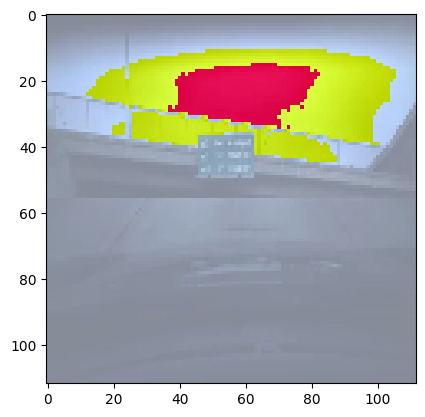

In [123]:
show(next(generator)[0][0][0])

# Construct the model

## 3DCNN model 

In [124]:
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, LSTM, Reshape
model = Sequential()
input_shape=(TIMESTEPS, FRAME_H, FRAME_W, 3) # l, h, w, c

# 1st layer group
model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))

# 2nd layer group
model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

# 3rd layer group
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

# 4th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

# 5th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
model.add(Flatten())
 
# FC layers group
model.add(Dense(4096, activation='relu', name='fc6'))
model.add(Dropout(.5))
model.add(Dense(4096, activation='relu', name='fc7'))
model.add(Dropout(.5))
model.add(Dense(1,    activation='linear', name='fc8'))

In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)   

## 3DCNN with LSTM and GRU layer

In [58]:
def createModel(insert_network=None):
    model = Sequential()


    input_shape=(TIMESTEPS, FRAME_H, FRAME_W, 3) # l, h, w, c

     # 1st layer group
    model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape)) 
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1')) 

     # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

  # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

  # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

  # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))

  # add RNN
    if insert_network == "lstm":
    # add LSTM layer
        model.add(TimeDistributed(Flatten(), input_shape=(TIMESTEPS, FRAME_H // 2, FRAME_W // 2, 512), name='timedis1'))
        model.add(LSTM(128, return_sequences=True, name='lstm'))
        model.add(TimeDistributed(Dense(128, activation='relu'), name='dense1'))
        print("original model plus lmst layer")

    elif insert_network == 'gru':
    # add GRU layer
        model.add(TimeDistributed(Flatten(), input_shape=(TIMESTEPS, FRAME_H // 2, FRAME_W // 2, 512), name='timedis1'))
        model.add(GRU(128, return_sequences=True, name='gru'))
        model.add(TimeDistributed(Dense(128, activation='relu'), name='dense1'))
        print("original model plus gru layer")

    else:
        print("use orirginal model")

    model.add(Flatten())
  
  # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6')) # 4096 <- 8192 // 2 
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(1,    activation='linear', name='fc8'))

    return model

In [59]:
model = createModel()
model_add_lstm = createModel('lstm')
model_add_gru = createModel('gru')

use orirginal model


2023-05-21 23:17:39.441901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 23:17:39.442566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 23:17:39.443209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

original model plus lmst layer
original model plus gru layer


2023-05-21 23:17:39.680206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 23:17:39.680968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 23:17:39.681543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [60]:
model_add_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)   

## ResNet18

In [41]:
# Create a resnet block

def resnetBlock(x, filters, strides=(1, 1, 1), blockname=''):
    x_0 = x # x_0: initial state of x
    x = Conv3D(filters[0], (3, 3, 3), strides=strides, padding='same', name=blockname + '_conv1')(x)
    x = BatchNormalization(name=blockname + '_bn1')(x)
    x = Activation('relu', name=blockname + '_fc1')(x)
    x = Conv3D(filters[1], (3, 3, 3), padding='same', name=blockname + '_conv2')(x)
    x = BatchNormalization(name=blockname + '_bn2')(x)
  
    if strides != (1, 1, 1) or x_0.shape[4] != filters[1]:
        x = Conv3D(filters[1], (1, 1, 1), strides=strides, padding='valid', name=blockname + '_down_samp_conv1')(x_0)
        x = BatchNormalization(name=blockname + '_down_samp_bn1')(x_0)
  
    x = Add(name=blockname + '_add')([x, x_0])
    x = Activation('relu', name=blockname + '_fc2')(x)
  
    return x

In [42]:
# Create a reset18 model

def renset18():
    input_tensor = Input(shape=(TIMESTEPS, FRAME_H, FRAME_W, 3))
  
    # Step 1
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same', name='conv1')(input_tensor)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='fc1')(x)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='pool1')(x)
  
    # Step 2
    x = resnetBlock(x, filters=[64, 64], strides=(1, 1, 1), blockname='resnetblock1a')
    x = resnetBlock(x, filters=[64, 64], blockname='resnetblock1b')
  
    # Step 3
    x = resnetBlock(x, filters=[128, 128], strides=(2, 2, 2), blockname='resnetblock2a')
    x = resnetBlock(x, filters=[128, 128], blockname='resnetblock2b')
  
    # Step 4
    x = resnetBlock(x, filters=[256, 256], strides=(2, 2, 2), blockname='resnetblock3a')
    x = resnetBlock(x, filters=[256, 256], blockname='resnetblock3b')
  
    # Step 5
    x = resnetBlock(x, filters=[512, 512], strides=(2, 2, 2), blockname='resnetblock4a')
    x = resnetBlock(x, filters=[512, 512], blockname='resnetblock4b')
  
    x = GlobalAveragePooling3D(name='pool2')(x)
    x = Dense(1, activation='linear', name='fc2')(x)
  
    model = Model(inputs=input_tensor, outputs=x)
  
    return model

In [43]:
resnet18_model = renset18()

In [44]:
resnet18_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv1 (Conv3D)                 (None, 8, 56, 56, 6  65920       ['input_2[0][0]']                
                                4)                                                                
                                                                                                  
 bn1 (BatchNormalization)       (None, 8, 56, 56, 6  256         ['conv1[0][0]']                  
                                4)                                                          

# Load weights pretrained on the Sports-1M dataset

In [55]:
sports_1m = h5py.File('c3d-sports1M_weights.h5', mode='r')

for i in range(len(model.layers)):
    layer = model.layers[i]
    layer_name = 'layer_' + str(i)
    
    weights = sports_1m[layer_name].values()
    # print([np.array(weight) for j, weight in enumerate(weights)])
    weights = [np.array(weight) for weight in weights] # original weights = [weight.value for weight in weights]
    #weights = [np.array(weight) if len(weight.shape) < 4 else weight.transpose(2,3,4,1,0) for weight in weights]
    weights = [np.array(weight) if len(weight.shape) < 4 else np.transpose(weight, (2,3,4,1,0)) for weight in weights]

    layer.set_weights(weights)
    
    # ignore the last 2 layer, 1 dropout and 1 dense
    if i > len(model.layers) - 3:
        break

In [137]:
for layer in model.layers:
    has_weights = False
    for weight in layer.weights:

        if weight.numpy().any() > 0:
            has_weights = True
            break

    if has_weights:
        print("yes")  # Print "yes" if the layer has weights
    else:
        print("no")  # Print "no" if the layer does not have weights



yes
no
yes
no
yes
yes
no
yes
yes
no
yes
yes
no
no
no
yes
no
yes
no
yes


# Train the network

## Training 3DCNN with

TIMESTEP : 10

epochs : 50

batch_size : 4

optimizer : SGD with lr=1e-5, decay=0.0005, momentum=0.9

Loss : MSE

In [63]:
### #3d CNN TITESTEPS 10
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weight_cnn3d_time10.h5', monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True, mode='min', save_freq=1)
epochs = 50


split_ratio = 0.90
TIMESTEPS = 10
indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)


train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator(train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator(valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [65]:


sgd = tf.keras.optimizers.legacy.SGD(lr=1e-5, decay=0.0005, momentum=0.9)
resnet18_model.compile(loss=custom_loss, optimizer=sgd,metrics=['mse'])

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=adam)

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

resnet18_model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 25, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint], 
                    max_queue_size = 8)

Epoch 1/25


/tmp/ipykernel_821268/272010162.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet18_model.fit_generator(generator = gen_train.get_gen(),
2023-05-24 21:50:58.061638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


459/459 [==============================] - ETA: 0s - loss: 26.5345 - mse: 26.5345

2023-05-24 21:55:01.002517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


459/459 [==============================] - 252s 547ms/step - loss: 26.5345 - mse: 26.5345 - val_loss: 17.2337 - val_mse: 17.2337
Epoch 2/25
459/459 [==============================] - 252s 549ms/step - loss: 27.1044 - mse: 27.1044 - val_loss: 14.8797 - val_mse: 14.8797
Epoch 3/25
459/459 [==============================] - 252s 549ms/step - loss: 27.7834 - mse: 27.7834 - val_loss: 13.4881 - val_mse: 13.4881
Epoch 4/25
459/459 [==============================] - 252s 549ms/step - loss: 28.2225 - mse: 28.2225 - val_loss: 13.0720 - val_mse: 13.0720
Epoch 5/25
459/459 [==============================] - 252s 549ms/step - loss: 29.0515 - mse: 29.0515 - val_loss: 12.7966 - val_mse: 12.7966
Epoch 6/25
459/459 [==============================] - 252s 549ms/step - loss: 29.7440 - mse: 29.7440 - val_loss: 12.6368 - val_mse: 12.6368
Epoch 7/25
459/459 [==============================] - 252s 549ms/step - loss: 30.8618 - mse: 30.8618 - val_loss: 12.6421 - val_mse: 12.6421
Epoch 8/25
459/459 [===========

## Training ResnEt18 with

TIMESTEP : 16

epochs : 5

batch_size : 4

optimizer : AdamW with learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

In [50]:
epochs = 5
best_val_loss = float('inf')
best_weights_path = "best_resnet18_time_8.h5"  # Path to save the best model weights
from tensorflow.keras.optimizers import AdamW
# Compile the model
adam = AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
resnet18_model.compile(loss=custom_loss, optimizer=adam)
#sgd = tf.keras.optimizers.legacy.SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#resnet18_model.compile(loss=custom_loss, optimizer=sgd)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training
    resnet18_model.fit_generator(generator=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1)
    
    # Validation
    val_loss = resnet18_model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        resnet18_model.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/5


/tmp/ipykernel_821268/2051222323.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet18_model.fit_generator(generator=gen_train.get_gen(),
2023-05-24 20:26:22.961339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


573/573 [==============================] - 221s 383ms/step - loss: 24.1253


/tmp/ipykernel_821268/2051222323.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = resnet18_model.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-24 20:30:03.780421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 9s 134ms/step - loss: 48.3034
Validation loss: 48.30335998535156
Best model saved!
Epoch 2/5


2023-05-24 20:30:12.630808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 2/63 [..............................] - ETA: 7s - loss: 51.4347

2023-05-24 20:33:52.247897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 9s 139ms/step - loss: 13.9060
Validation loss: 13.90595531463623
Best model saved!
Epoch 3/5


2023-05-24 20:34:01.262351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 2/63 [..............................] - ETA: 7s - loss: 27.2655

2023-05-24 20:37:41.542451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 8s 128ms/step - loss: 13.7675
Validation loss: 13.767481803894043
Best model saved!
Epoch 4/5


2023-05-24 20:37:49.858663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/63 [..............................] - ETA: 3s - loss: 0.2226

2023-05-24 20:41:29.288842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 8s 133ms/step - loss: 46.1057
Validation loss: 46.10573959350586
Epoch 5/5


2023-05-24 20:41:37.877922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 56/573 [=>............................] - ETA: 3:17 - loss: 61.1184

KeyboardInterrupt: 

## Training ResnEt18 with

TIMESTEP : 16

epochs : 25

batch_size : 4

optimizer : SGD with lr=1e-5, decay=0.0005, momentum=0.9

Loss : MSE

In [14]:
### 
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weight_resnet3d.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq=1)


split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator(train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator(valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [57]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [24]:
resnet18_model.load_weights('model_resnetscracth0_weigh.h5')

In [17]:
#tb_counter  = max([int(num) for num in os.listdir('../logs/speed/')] or [0]) + 1
#tensorboard = TensorBoard(log_dir='../logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

sgd = tf.keras.optimizers.legacy.SGD(lr=1e-5, decay=0.0005, momentum=0.9)
resnet18_model.compile(loss=custom_loss, optimizer=sgd,metrics=['mse'])

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=adam)

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

resnet18_model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 25, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint], 
                    max_queue_size = 8)

/home/meremina/mariias_env/lib/python3.9/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_568936/3402067976.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet18_model.fit_generator(generator = gen_train.get_gen(),


Epoch 1/25


2023-05-23 19:14:51.987216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/286 [==============================] - ETA: 0s - loss: 19.1296 - mse: 19.1296

2023-05-23 19:18:46.375544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 243s 846ms/step - loss: 19.1296 - mse: 19.1296 - val_loss: 5.1572 - val_mse: 5.1572
Epoch 2/25
286/286 [==============================] - 243s 846ms/step - loss: 19.1693 - mse: 19.1693 - val_loss: 3.9293 - val_mse: 3.9293
Epoch 3/25
286/286 [==============================] - 242s 844ms/step - loss: 18.4440 - mse: 18.4440 - val_loss: 2.6947 - val_mse: 2.6947
Epoch 4/25
286/286 [==============================] - 242s 845ms/step - loss: 18.5631 - mse: 18.5631 - val_loss: 4.5872 - val_mse: 4.5872
Epoch 5/25
286/286 [==============================] - 243s 846ms/step - loss: 18.1621 - mse: 18.1621 - val_loss: 2.9677 - val_mse: 2.9677
Epoch 5: early stopping


## Training ResnEt18 with

TIMESTEP : 16

epochs : 50

batch_size : 4

optimizer : SGD with lr=1e-5, decay=0.0005, momentum=0.9

Loss : MSE

In [14]:
### resnet scatch

split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [15]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [16]:
epochs = 50
checkpoint = ModelCheckpoint('best_model_resnet_weigh4.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'model_resnetscracth0_weigh.h5'  # Path to save the best model weights

# Compile the model
sgd = tf.keras.optimizers.legacy.SGD(lr=1e-5, decay=0.0005, momentum=0.9)
resnet18_model.compile(loss=custom_loss, optimizer=sgd)
#from tensorflow.keras.optimizers import AdamW

#adam = AdamW(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#resnet18_model.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        resnet18_model.load_weights('model_resnetscracth0_weigh.h5')
    # Training
    resnet18_model.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = resnet18_model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        resnet18_model.save_weights(best_weights_path)
        print("Best model saved!")

/home/meremina/mariias_env/lib/python3.9/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50


2023-05-23 13:24:22.875563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 233s 811ms/step - loss: 25.0604


/tmp/ipykernel_503196/4223763070.py:34: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = resnet18_model.evaluate_generator(generator=gen_valid.get_gen(),


 1/32 [..............................] - ETA: 5s - loss: 0.3871

2023-05-23 13:28:16.361870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 271ms/step - loss: 35.8357
Validation loss: 35.83567810058594
Best model saved!
Epoch 2/50


2023-05-23 13:28:25.435446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 2.5126

2023-05-23 13:32:18.842664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 281ms/step - loss: 17.2755
Validation loss: 17.27550506591797
Best model saved!
Epoch 3/50


2023-05-23 13:32:28.106315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 21.3990

2023-05-23 13:36:21.413711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 277ms/step - loss: 5.5487
Validation loss: 5.5487470626831055
Best model saved!
Epoch 4/50


2023-05-23 13:36:30.571435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 10.6489

2023-05-23 13:40:23.526900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 278ms/step - loss: 7.4457
Validation loss: 7.445725917816162
Epoch 5/50


2023-05-23 13:40:32.694434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 3s - loss: 14.6863

2023-05-23 13:44:25.905423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 277ms/step - loss: 4.8622
Validation loss: 4.862170696258545
Best model saved!
Epoch 6/50


2023-05-23 13:44:35.101650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 9.9298

2023-05-23 13:48:28.702955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 271ms/step - loss: 5.4656
Validation loss: 5.465592861175537
Epoch 7/50


2023-05-23 13:48:37.665124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 9.8031

2023-05-23 13:52:30.750529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 279ms/step - loss: 4.6699
Validation loss: 4.669906139373779
Best model saved!
Epoch 8/50


2023-05-23 13:52:39.992738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 9.9437

2023-05-23 13:56:33.164306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 280ms/step - loss: 4.5852
Validation loss: 4.5851616859436035
Best model saved!
Epoch 9/50


2023-05-23 13:56:42.403280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 9.8525

2023-05-23 14:00:35.514556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 270ms/step - loss: 4.2671
Validation loss: 4.267140865325928
Best model saved!
Epoch 10/50


2023-05-23 14:00:44.477435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 5.7039

2023-05-23 14:04:37.475349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 276ms/step - loss: 6.1580
Validation loss: 6.158005714416504
Epoch 11/50


2023-05-23 14:04:46.580542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 6.7955

2023-05-23 14:08:39.969489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 274ms/step - loss: 4.5597
Validation loss: 4.559737682342529
Epoch 12/50


2023-05-23 14:08:49.030458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 7.6906

2023-05-23 14:12:42.194014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 273ms/step - loss: 3.9130
Validation loss: 3.913022518157959
Best model saved!
Epoch 13/50


2023-05-23 14:12:51.217355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 8.3154

2023-05-23 14:16:44.080709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 269ms/step - loss: 4.1933
Validation loss: 4.193337440490723
Epoch 14/50


2023-05-23 14:16:52.970054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 10.5097

2023-05-23 14:20:45.660171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 278ms/step - loss: 3.4890
Validation loss: 3.4890363216400146
Best model saved!
Epoch 15/50


2023-05-23 14:20:54.851015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 8.7616

2023-05-23 14:24:47.560924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 273ms/step - loss: 3.4527
Validation loss: 3.4527223110198975
Best model saved!
Epoch 16/50


2023-05-23 14:24:56.598160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 7.4647

2023-05-23 14:28:49.414628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 280ms/step - loss: 3.1547
Validation loss: 3.1547441482543945
Best model saved!
Epoch 17/50


2023-05-23 14:28:58.631165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 17.9073

2023-05-23 14:32:51.333941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 280ms/step - loss: 7.2641
Validation loss: 7.264115810394287
Epoch 18/50


2023-05-23 14:33:00.562359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 11.2641

2023-05-23 14:36:53.620693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 270ms/step - loss: 4.0773
Validation loss: 4.077349662780762
Epoch 19/50


2023-05-23 14:37:02.541422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 10.3918

2023-05-23 14:40:55.349978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 277ms/step - loss: 3.8612
Validation loss: 3.8612470626831055
Epoch 20/50


2023-05-23 14:41:04.503490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 6.2327

2023-05-23 14:44:57.456183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 269ms/step - loss: 2.6980
Validation loss: 2.6980388164520264
Best model saved!
Epoch 21/50


2023-05-23 14:45:06.378607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 13.3113

2023-05-23 14:48:58.978247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 266ms/step - loss: 6.2241
Validation loss: 6.224142074584961
Epoch 22/50


2023-05-23 14:49:07.791045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 13.5061

2023-05-23 14:53:00.975674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 278ms/step - loss: 6.5065
Validation loss: 6.506547927856445
Epoch 23/50


2023-05-23 14:53:10.140735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 13.6163

2023-05-23 14:57:03.081113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 278ms/step - loss: 6.9945
Validation loss: 6.994508743286133
Epoch 24/50


2023-05-23 14:57:12.260530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 12.9994

2023-05-23 15:01:05.187757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 267ms/step - loss: 7.1007
Validation loss: 7.100729465484619
Epoch 25/50


2023-05-23 15:01:14.024764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/32 [..............................] - ETA: 2s - loss: 15.6968

2023-05-23 15:05:06.752003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 269ms/step - loss: 11.0029
Validation loss: 11.002889633178711
Epoch 26/50


2023-05-23 15:05:15.610307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/286 [==================>...........] - ETA: 1:19 - loss: 19.6037

KeyboardInterrupt: 

## Training 3D CNN + LSTM with

TIMESTEP : 16

epochs : 50

batch_size : 32

optimizer : AdamW with learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

Result : overfitting

In [70]:
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)


train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=32, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=32, timesteps=TIMESTEPS, jitter = False)

In [85]:
epochs = 50
checkpoint = ModelCheckpoint('best_model_ltsm_weigh4.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'model_add_ltsm_weigh.h5'  # Path to save the best model weights

# Compile the model
#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_add_lstm.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        model_add_lstm.load_weights('model_add_ltsm_weigh.h5')
    # Training
    model_add_lstm.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model_add_lstm.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_add_gru.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/50


ValueError: Invalid bias shape: (2, 384)

## Training 3D CNN + GRU with

TIMESTEP : 16

epochs : 50

batch_size : 32

optimizer : AdamW with learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

Result : overfitting

In [62]:
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)


train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=32, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=32, timesteps=TIMESTEPS, jitter = False)

In [63]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [65]:
epochs = 50
checkpoint = ModelCheckpoint('best_model_glu_weigh4.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'model_add_gru_weigh.h5'  # Path to save the best model weights

# Compile the model
#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_add_gru.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        model.load_weights('weights.h5')
    # Training
    model_add_gru.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model_add_gru.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_add_gru.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/50


2023-05-21 23:31:14.953204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 23:31:15.061966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 23:31:15.062638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

35/35 [==============================] - 1325s 37s/step - loss: 111.8757


/tmp/ipykernel_3921612/814629099.py:34: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model_add_gru.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-21 23:53:21.609258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 23:53:21.711066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 23:

4/4 [==============================] - 12s 3s/step - loss: 13.0485
Validation loss: 13.048469543457031
Best model saved!
Epoch 2/50


2023-05-21 23:53:35.826148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1297s 36s/step - loss: 135.0518


2023-05-22 00:15:15.342049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 27.5125
Validation loss: 27.51249122619629
Epoch 3/50


2023-05-22 00:15:28.836128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1312s 37s/step - loss: 101.1999


2023-05-22 00:37:22.710695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 23.5631
Validation loss: 23.563081741333008
Epoch 4/50


2023-05-22 00:37:36.222563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1315s 37s/step - loss: 105.1164


2023-05-22 00:59:32.879153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 30.7967
Validation loss: 30.796741485595703
Epoch 5/50


2023-05-22 00:59:46.502852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1322s 37s/step - loss: 97.7903


2023-05-22 01:21:50.057455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 30.9593
Validation loss: 30.95931625366211
Epoch 6/50


2023-05-22 01:22:03.667271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1323s 37s/step - loss: 97.7879


2023-05-22 01:44:08.918435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 33.3966
Validation loss: 33.396644592285156
Epoch 7/50


2023-05-22 01:44:22.539778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1314s 37s/step - loss: 95.7617


2023-05-22 02:06:18.585933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 34.6652
Validation loss: 34.6651611328125
Epoch 8/50


2023-05-22 02:06:32.216235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1319s 37s/step - loss: 95.2665


2023-05-22 02:28:33.250685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 35.7482
Validation loss: 35.74819564819336
Epoch 9/50


2023-05-22 02:28:46.861684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1324s 37s/step - loss: 94.5588


2023-05-22 02:50:53.032201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 36.3318
Validation loss: 36.33184814453125
Epoch 10/50


2023-05-22 02:51:06.646984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1321s 37s/step - loss: 93.0300


2023-05-22 03:13:09.256480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 37.7855
Validation loss: 37.78548049926758
Epoch 11/50


2023-05-22 03:13:22.808953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1315s 37s/step - loss: 92.3671


2023-05-22 03:35:20.224544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 38.2081
Validation loss: 38.20805740356445
Epoch 12/50


2023-05-22 03:35:33.870460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1317s 37s/step - loss: 91.7932


2023-05-22 03:57:32.510744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 39.6912
Validation loss: 39.691246032714844
Epoch 13/50


2023-05-22 03:57:46.259539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1320s 37s/step - loss: 90.4458


2023-05-22 04:19:48.330501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 39.6959
Validation loss: 39.6959342956543
Epoch 14/50


2023-05-22 04:20:01.861058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1329s 37s/step - loss: 90.4443


2023-05-22 04:42:12.649703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 41.5744
Validation loss: 41.57441329956055
Epoch 15/50


2023-05-22 04:42:26.133630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1316s 37s/step - loss: 89.4816


2023-05-22 05:04:23.668242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 40.4476
Validation loss: 40.44758605957031
Epoch 16/50


2023-05-22 05:04:37.209921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1329s 37s/step - loss: 89.7402


2023-05-22 05:26:47.892325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 42.1647
Validation loss: 42.16469955444336
Epoch 17/50


2023-05-22 05:27:01.526297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1315s 37s/step - loss: 89.4625


2023-05-22 05:48:58.554447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 42.3843
Validation loss: 42.38425827026367
Epoch 18/50


2023-05-22 05:49:12.038793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1320s 37s/step - loss: 89.0545


2023-05-22 06:11:13.720429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 42.8903
Validation loss: 42.8902587890625
Epoch 19/50


2023-05-22 06:11:27.327780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1315s 37s/step - loss: 88.1616


2023-05-22 06:33:24.456470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 43.1642
Validation loss: 43.16420364379883
Epoch 20/50


2023-05-22 06:33:37.993517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1328s 37s/step - loss: 88.4595


2023-05-22 06:55:47.825219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 43.2932
Validation loss: 43.293216705322266
Epoch 21/50


2023-05-22 06:56:01.445772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1304s 36s/step - loss: 88.2931


2023-05-22 07:17:47.281971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 43.4824
Validation loss: 43.4824333190918
Epoch 22/50


2023-05-22 07:18:01.003070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1310s 37s/step - loss: 87.7536


2023-05-22 07:39:53.097136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 44.4340
Validation loss: 44.43400955200195
Epoch 23/50


2023-05-22 07:40:06.778624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1310s 37s/step - loss: 87.2498


2023-05-22 08:01:58.638987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 45.0176
Validation loss: 45.017635345458984
Epoch 24/50


2023-05-22 08:02:12.364316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1293s 36s/step - loss: 86.7124


2023-05-22 08:23:47.079095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 45.5194
Validation loss: 45.51941680908203
Epoch 25/50


2023-05-22 08:24:00.656423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1304s 36s/step - loss: 86.8498


2023-05-22 08:45:46.318810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 45.2377
Validation loss: 45.23772048950195
Epoch 26/50


2023-05-22 08:45:59.957091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1310s 37s/step - loss: 86.9682


2023-05-22 09:07:52.233052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 45.3064
Validation loss: 45.306396484375
Epoch 27/50


2023-05-22 09:08:05.768496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1297s 36s/step - loss: 86.4505


2023-05-22 09:29:44.408619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 46.6029
Validation loss: 46.60289764404297
Epoch 28/50


2023-05-22 09:29:57.991833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1292s 36s/step - loss: 86.0975


2023-05-22 09:51:31.705148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 45.7374
Validation loss: 45.73741912841797
Epoch 29/50


2023-05-22 09:51:45.301088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

## Training 3D CNN 

TIMESTEP : 16

epochs : 16

batch_size : 32 and shaffle : True

optimizer : AdamW with learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE


In [32]:
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)


valid_indices= list(indices[0:int(len(indices)*0.1)])
train_indices = list(indices[int(len(valid_indices)):])

gen_train = BatchGenerator( train_indices, batch_size=32, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=32, timesteps=TIMESTEPS, jitter = False)

In [33]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [34]:
epochs = 16
checkpoint = ModelCheckpoint('best_model_weigh4.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'shuffleweigh4_sport.h5'  # Path to save the best model weights

# Compile the model
#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        model.load_weights('weights.h5')
    # Training
    model.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/16


2023-05-20 15:55:41.013010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1310s 37s/step - loss: 150.0790


/tmp/ipykernel_3921612/4250588927.py:34: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-20 16:17:32.617996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 11s 3s/step - loss: 14.4795
Validation loss: 14.479499816894531
Best model saved!
Epoch 2/16


2023-05-20 16:17:46.354460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1307s 36s/step - loss: 78.0426


2023-05-20 16:39:34.933689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 11s 3s/step - loss: 66.3872
Validation loss: 66.38721466064453
Epoch 3/16


2023-05-20 16:39:48.475205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1310s 37s/step - loss: 77.4561


2023-05-20 17:01:40.154834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 11s 3s/step - loss: 70.2651
Validation loss: 70.26512908935547
Epoch 4/16


2023-05-20 17:01:53.705910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1306s 36s/step - loss: 72.4104


2023-05-20 17:23:41.390619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 11s 3s/step - loss: 77.7939
Validation loss: 77.79387664794922
Epoch 5/16


2023-05-20 17:23:54.871459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/35 [=======>......................] - ETA: 15:41 - loss: 109.9461

KeyboardInterrupt: 

## Training 3D CNN 

TIMESTEP : 16

epochs : 16

batch_size : 4 and shaffle : True

optimizer : AdamW with learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

In [22]:
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [24]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [ ]:
epochs = 16
checkpoint = ModelCheckpoint('best_model_weigh4.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'shuffleweigh4.h5'  # Path to save the best model weights

# Compile the model
#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        model.load_weights('weights.h5')
    # Training
    model.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/16


2023-05-19 23:05:53.661022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1442s 5s/step - loss: 31.5337


/tmp/ipykernel_3747540/3571575218.py:34: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-19 23:29:56.135804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 371ms/step - loss: 12.6855
Validation loss: 12.685486793518066
Best model saved!
Epoch 2/16


2023-05-19 23:30:08.515887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1440s 5s/step - loss: 44.0177


2023-05-19 23:54:08.635740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 372ms/step - loss: 13.1815
Validation loss: 13.181544303894043
Epoch 3/16


2023-05-19 23:54:20.791421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1440s 5s/step - loss: 47.0899


2023-05-20 00:18:21.572346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 370ms/step - loss: 12.1988
Validation loss: 12.198845863342285
Best model saved!
Epoch 4/16


2023-05-20 00:18:33.902826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1443s 5s/step - loss: 43.6974


2023-05-20 00:42:36.841057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 371ms/step - loss: 12.2052
Validation loss: 12.205243110656738
Epoch 5/16


2023-05-20 00:42:48.963093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1446s 5s/step - loss: 42.8027


2023-05-20 01:06:55.399175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 372ms/step - loss: 11.2963
Validation loss: 11.296317100524902
Best model saved!
Epoch 6/16


2023-05-20 01:07:07.802061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1456s 5s/step - loss: 40.3664


2023-05-20 01:31:24.012542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 373ms/step - loss: 11.0703
Validation loss: 11.070306777954102
Best model saved!
Epoch 7/16


2023-05-20 01:31:36.422023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1465s 5s/step - loss: 36.9407


2023-05-20 01:56:02.011629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 371ms/step - loss: 10.6477
Validation loss: 10.647706031799316
Best model saved!
Epoch 8/16


2023-05-20 01:56:14.496607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/286 [============>.................] - ETA: 13:46 - loss: 38.4787

## Training 3D CNN 

TIMESTEP : 16

epochs : 15

batch_size : 32 and shaffle : False

optimizer : AdamW with learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

In [12]:
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)


train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=32, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=32, timesteps=TIMESTEPS, jitter = True)

In [13]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss


In [14]:
epochs = 15
checkpoint = ModelCheckpoint('best_model_weigh32.h5', save_weights_only=True, save_best_only=True)
best_val_loss = float('inf')
best_weights_path = 'bestweigh32__.h5'  # Path to save the best model weights

# Compile the model
#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    
    # Load the weights from the previous step (if available)
    if epoch == 0:
        model.load_weights('bestweigh32.h5')
    # Training
    model.fit(x=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [checkpoint],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/15


2023-05-19 16:30:12.127495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1304s 36s/step - loss: 79.7984


/tmp/ipykernel_3747540/946514515.py:34: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-19 16:51:58.766328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 96.5285
Validation loss: 96.52848815917969
Best model saved!
Epoch 2/15


2023-05-19 16:52:12.814216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1298s 36s/step - loss: 68.7275


2023-05-19 17:13:53.358970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 74.6345
Validation loss: 74.63447570800781
Best model saved!
Epoch 3/15


2023-05-19 17:14:07.328440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1302s 36s/step - loss: 70.3770


2023-05-19 17:35:51.273904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 68.2310
Validation loss: 68.23104095458984
Best model saved!
Epoch 4/15


2023-05-19 17:36:05.241361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1300s 36s/step - loss: 69.5914


2023-05-19 17:57:47.232903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 62.0058
Validation loss: 62.00579071044922
Best model saved!
Epoch 5/15


2023-05-19 17:58:01.143511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1300s 36s/step - loss: 69.0257


2023-05-19 18:19:42.932387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 57.4063
Validation loss: 57.4062614440918
Best model saved!
Epoch 6/15


2023-05-19 18:19:56.887141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1300s 36s/step - loss: 67.0649


2023-05-19 18:41:39.481366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 44.3927
Validation loss: 44.3926887512207
Best model saved!
Epoch 7/15


2023-05-19 18:41:53.331225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1301s 36s/step - loss: 67.4702


2023-05-19 19:03:36.506036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 46.1417
Validation loss: 46.141746520996094
Epoch 8/15


2023-05-19 19:03:50.182709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1300s 36s/step - loss: 61.2605


2023-05-19 19:25:31.878091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 34.4075
Validation loss: 34.40749740600586
Best model saved!
Epoch 9/15


2023-05-19 19:25:45.873505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1300s 36s/step - loss: 57.7169


2023-05-19 19:47:28.106727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 31.9593
Validation loss: 31.95926284790039
Best model saved!
Epoch 10/15


2023-05-19 19:47:41.929685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1304s 36s/step - loss: 49.4391


2023-05-19 20:09:27.738378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 22.8048
Validation loss: 22.804805755615234
Best model saved!
Epoch 11/15


2023-05-19 20:09:41.647862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1299s 36s/step - loss: 43.5952


2023-05-19 20:31:22.582896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 22.4590
Validation loss: 22.458951950073242
Best model saved!
Epoch 12/15


2023-05-19 20:31:36.467323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1303s 36s/step - loss: 38.4246


2023-05-19 20:53:21.933275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 18.9079
Validation loss: 18.907943725585938
Best model saved!
Epoch 13/15


2023-05-19 20:53:35.842232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1296s 36s/step - loss: 33.1308


2023-05-19 21:15:14.026989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 20.5914
Validation loss: 20.591354370117188
Epoch 14/15


2023-05-19 21:15:27.806997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1298s 36s/step - loss: 30.3359


2023-05-19 21:37:08.287650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 19.4088
Validation loss: 19.40884017944336
Epoch 15/15


2023-05-19 21:37:21.980077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 1297s 36s/step - loss: 28.4169


2023-05-19 21:59:01.201316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 12s 3s/step - loss: 18.0266
Validation loss: 18.026609420776367
Best model saved!


## Training 3D CNN 

TIMESTEP : 16

epochs : 15

batch_size : 4 and shaffle : False

optimizer : AdamW with learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

In [139]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weightss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq=1)


split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir('images/')), TIMESTEPS)
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [84]:
from keras.callbacks import LearningRateScheduler

# Define your learning rate schedule function
def lr_schedule(batch):
    # Calculate the desired learning rate based on the batch number
    learning_rate = 1e-4
    if batch > 50:
        learning_rate *= 0.5
    if batch > 100:
        learning_rate *= 0.2
    return learning_rate

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)



In [23]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss


In [112]:
tb_counter = max([int(num) for num in os.listdir('logs/speed/') if num.isdigit()] or [0]) + 1
tensorboard = TensorBoard(log_dir='logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)
epochs = 15

best_val_loss = float('inf')
best_weights_path = 'bestweightlsmt.h5'  # Path to save the best model weights

# Compile the model
adam = AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training
    model.fit_generator(generator=gen_train.get_gen(),
                        steps_per_epoch=gen_train.get_size(),
                        epochs=1,  # Train for 1 epoch
                        verbose=1,
                        callbacks = [early_stop, checkpoint, tensorboard],
                        max_queue_size = 8)
    
    # Validation
    val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
                                        steps=gen_valid.get_size(),
                                        verbose=1)
    print(f"Validation loss: {val_loss}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_weights(best_weights_path)
        print("Best model saved!")

Epoch 1/15


/tmp/ipykernel_2628830/1847866544.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=gen_train.get_gen(),
2023-05-14 17:27:00.091174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-14 17:27:00.207770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:27:00.208481: I tensorflow/core/c

286/286 [==============================] - 1384s 5s/step - loss: 37.8845


/tmp/ipykernel_2628830/1847866544.py:24: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
2023-05-14 17:50:04.450684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-14 17:50:04.557087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 17:50:04.5

32/32 [==============================] - 12s 367ms/step - loss: 12.9235
Validation loss: 12.923473358154297
Best model saved!
Epoch 2/15


2023-05-14 17:50:16.779497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1382s 5s/step - loss: 38.1521


2023-05-14 18:13:19.482945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 12.8870
Validation loss: 12.886971473693848
Best model saved!
Epoch 3/15


2023-05-14 18:13:31.599360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 41.7418


2023-05-14 18:36:33.205920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 13.2641
Validation loss: 13.264090538024902
Epoch 4/15


2023-05-14 18:36:45.220225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 31.3433


2023-05-14 18:59:46.138308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 13.0915
Validation loss: 13.091503143310547
Epoch 5/15


2023-05-14 18:59:58.153326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1382s 5s/step - loss: 31.2132


2023-05-14 19:23:00.151273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 13.5999
Validation loss: 13.599854469299316
Epoch 6/15


2023-05-14 19:23:12.121941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1380s 5s/step - loss: 32.4865


2023-05-14 19:46:12.004787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 365ms/step - loss: 12.6758
Validation loss: 12.675835609436035
Best model saved!
Epoch 7/15


2023-05-14 19:46:24.087784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 36.6861


2023-05-14 20:09:25.110308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 12.6370
Validation loss: 12.637018203735352
Best model saved!
Epoch 8/15


2023-05-14 20:09:37.263914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1380s 5s/step - loss: 38.9460


2023-05-14 20:32:37.225863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 12.7255
Validation loss: 12.725472450256348
Epoch 9/15


2023-05-14 20:32:49.207457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 39.8918


2023-05-14 20:55:50.179730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 12.8762
Validation loss: 12.876237869262695
Epoch 10/15


2023-05-14 20:56:02.166761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1380s 5s/step - loss: 39.8556


2023-05-14 21:19:01.993878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 12.8966
Validation loss: 12.89657974243164
Epoch 11/15


2023-05-14 21:19:13.954458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1380s 5s/step - loss: 41.3687


2023-05-14 21:42:36.150320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 12.9532
Validation loss: 12.95324993133545
Epoch 12/15


2023-05-14 21:42:48.109371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 41.9131


2023-05-14 22:05:49.554096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 13.0510
Validation loss: 13.051044464111328
Epoch 13/15


2023-05-14 22:06:01.524955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1382s 5s/step - loss: 43.0849


2023-05-14 22:29:03.814644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 13.1115
Validation loss: 13.111472129821777
Epoch 14/15


2023-05-14 22:29:15.782853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1381s 5s/step - loss: 35.1139


2023-05-14 22:52:17.066256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 367ms/step - loss: 12.8984
Validation loss: 12.898356437683105
Epoch 15/15


2023-05-14 22:52:29.074594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


286/286 [==============================] - 1382s 5s/step - loss: 40.9639


2023-05-14 23:15:31.234262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 366ms/step - loss: 13.0664
Validation loss: 13.066424369812012


## Training 3D CNN 

TIMESTEP : 16

epochs : 5

batch_size : 4 and shaffle : True

optimizer : SGD with lr=1e-5, decay=0.0005, momentum=0.9

Loss : MSE

In [101]:
tb_counter  = max([int(num) for num in os.listdir('logs/speed/')] or [0]) + 1
tensorboard = TensorBoard(log_dir='logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(loss=custom_loss, optimizer=sgd)

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=adam)

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 5, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_queue_size = 8)

/tmp/ipykernel_2628830/4132114309.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = gen_train.get_gen(),


Epoch 1/5


2023-05-14 14:26:12.571608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 68/286 [======>.......................] - ETA: 17:23 - loss: 9.5250

KeyboardInterrupt: 

## Training 3D CNN 

TIMESTEP : 16

epochs : 3

batch_size : 4 and shaffle : True

optimizer : AdamW with learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08

Loss : MSE

In [141]:
#tb_counter  = max([int(num) for num in os.listdir('../logs/speed/')] or [0]) + 1
#tensorboard = TensorBoard(log_dir='../logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)#metrics=['mse']

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 3, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint], #callbacks = [early_stop, checkpoint, tensorboard,lr_scheduler], 
                    max_queue_size = 8)

/tmp/ipykernel_2628830/2570864435.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = gen_train.get_gen(),


Epoch 1/3


2023-05-16 16:44:14.869310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 19/286 [>.............................] - ETA: 22:19 - loss: 22.5597

KeyboardInterrupt: 

# Save and  load weights 

In [ ]:
# Save
model.save_weights('name.h5')

In [ ]:
#Load
model.load_weights('name.h5')

# Analyze the trained network

In [139]:
file_name = 'Test3_cut' # name without extension of arbitrary dashcam video
TIMESTEPS = 16
video_inp =  file_name + '.mp4'
video_out = file_name + '_out.mp4'
label_inp = open( file_name + '.txt', 'r').readlines() if os.path.exists(file_name + '.txt') else None
label_out = open(file_name + '_pred.txt', 'w')

video_reader = cv2.VideoCapture(video_inp)
h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (w, h))

x_batch_original = np.zeros((TIMESTEPS, h, w, 3))
x_batch = np.zeros((1, TIMESTEPS, FRAME_H, FRAME_W, 3))
frame_counter = 0
frame_counter_all = 0
curr_speed = 0.
acc_error = 0
import cv2


while(True):
    ret, image = video_reader.read()

    if ret == True:
        if frame_counter_all > -1: # only start processing from certain frame count
            x_batch_original[frame_counter] = image

            heigh = image.shape[0]
            image = image[np.concatenate([np.arange(int(heigh/3)), np.arange(int(heigh*2/3),heigh)]),:,:]
            image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
            image = normalize(image)

            x_batch[0, frame_counter] = image

            if frame_counter == TIMESTEPS - 1:

                curr_speed = model.predict(x_batch)[0][0]
                frame_counter = -1

                for i in range(TIMESTEPS):
                    image = x_batch_original[i]
                    caption = 'Speed (Predicted): ' + str("{0:.2f}".format(curr_speed))
                    image = cv2.putText(image, caption, (5,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

                    # write true speed if available
                    if label_inp is not None:
                        true_speed = float(label_inp[frame_counter_all-(TIMESTEPS-1)+i].strip())
                        caption = 'Speed (Actual): ' + str("{0:.2f}".format(true_speed))
                        image = cv2.putText(image, caption, (5,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
                        
                        acc_error += (curr_speed - true_speed) ** 2
                        caption = 'MSE: ' + str("{0:.2f}".format(acc_error/(frame_counter_all-TIMESTEPS+1+i+1)))
                        image = cv2.putText(image, caption, (5,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)                        

                    video_writer.write(np.uint8(image))
                    label_out.write(str(curr_speed) + '\n')

            frame_counter += 1
    else:
        break
    
    frame_counter_all += 1

video_reader.release()
video_writer.release()

label_out.close()

1/1 [==============================] - 0s 118ms/step


# Test code

In [23]:
video_out = 'test.mp4v'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (640, 480))

labels = open('test_pred.txt', 'w')

with open('inter.csv', 'r') as csvfile:
    print (csvfile.readline())
    
    for row in csvfile:
        if 'center' in row:
            row = row.split(',')

            image = cv2.imread(row[5])
            
            video_writer.write(np.uint8(image))
            #labels.write(row[8] + '\n')
            labels.write(str(float(row[8])*0.621371) + '\n')
            
video_writer.release()
labels.close()

,,,,,,



In [ ]:
indices = range(16, len(os.listdir('images/')), 16)
np.random.shuffle(indices)

train_indices = indices[0:int(len(indices)*0.8)]
valid_indices = indices[int(len(indices)*0.8):]